Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Epoch: 1, Discriminator Loss:  7.3350, Generator Loss: 24.1471
Epoch: 2, Discriminator Loss:  7.8051, Generator Loss:  9.3090
Epoch: 3, Discriminator Loss:  0.1090, Generator Loss: 10.4793
Epoch: 4, Discriminator Loss:  1.1719, Generator Loss: 10.3285
Epoch: 5, Discriminator Loss:  0.2715, Generator Loss:  5.1284
Epoch: 6, Discriminator Loss:  0.2635, Generator Loss:  3.8027
Epoch: 7, Discriminator Loss:  0.1226, Generator Loss:  5.6110
Epoch: 8, Discriminator Loss:  0.0936, Generator Loss:  6.1995
Epoch: 9, Discriminator Loss:  0.2065, Generator Loss:  6.0251
Epoch: 10, Discriminator Loss:  0.1680, Generator Loss:  7.2554
Epoch: 11, Discriminator Loss:  0.5078, Generator Loss:  9.9431
Epoch: 12, Discriminator Loss:

C:\Users\my\Anaconda3\lib\site-packages\ipykernel_launcher.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\my\Anaconda3\lib\site-packages\ipykernel_launcher.py:179: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


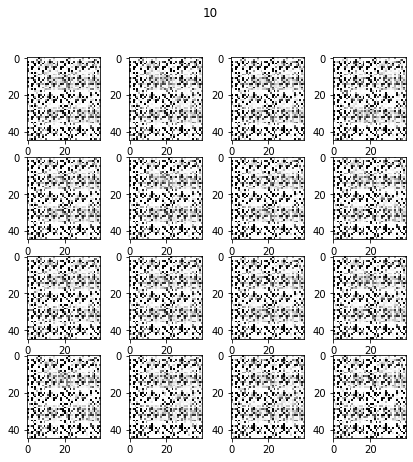

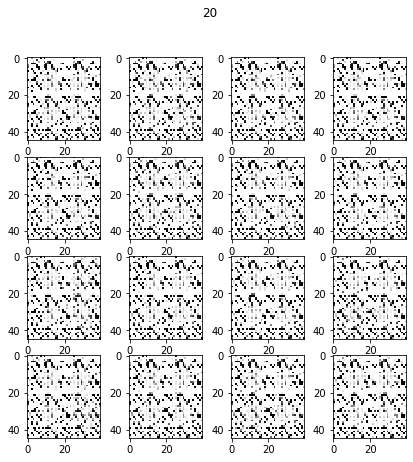

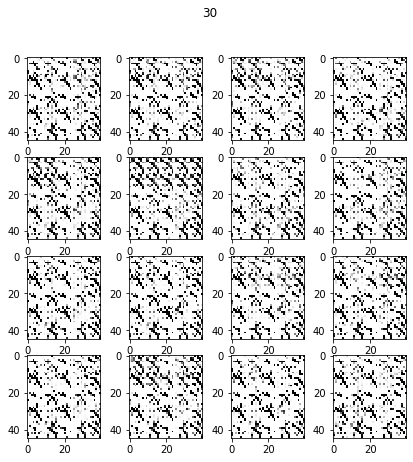

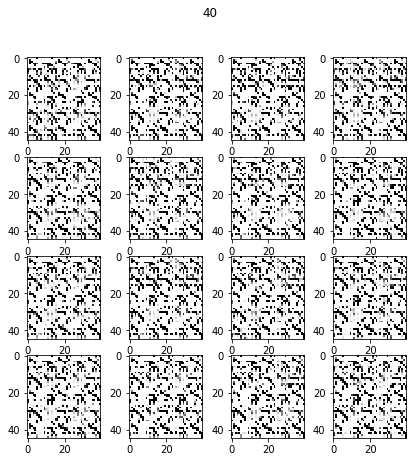

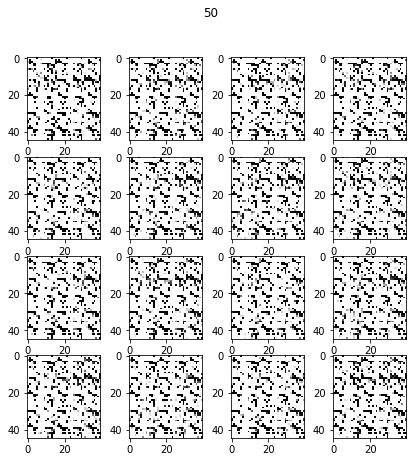

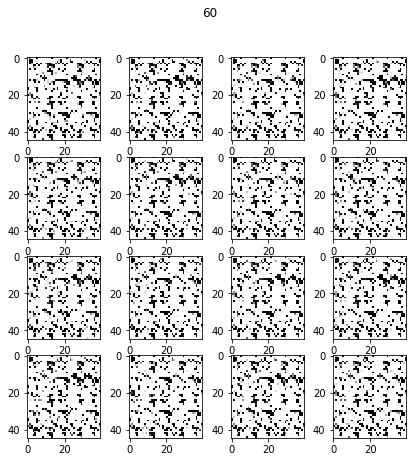

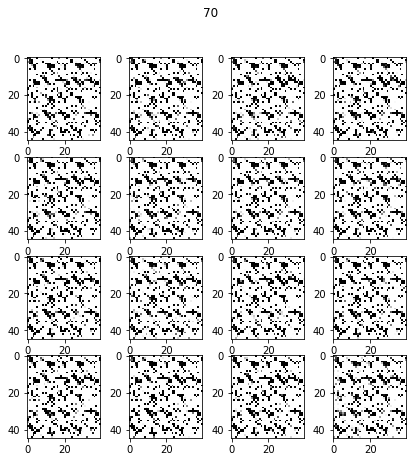

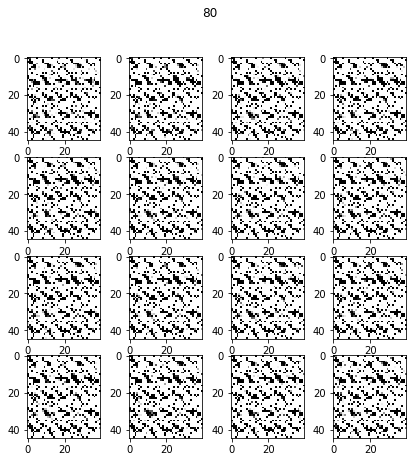

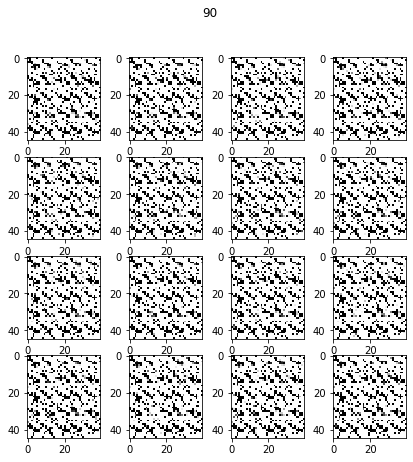

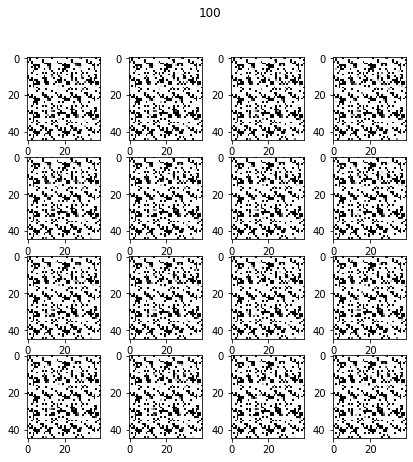

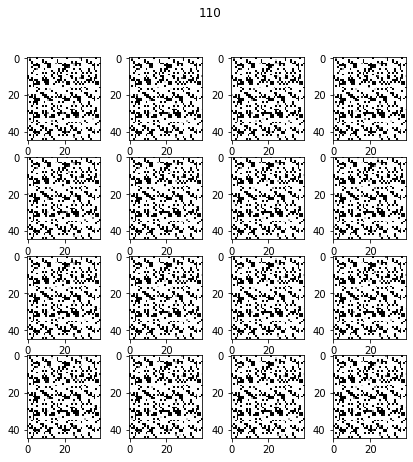

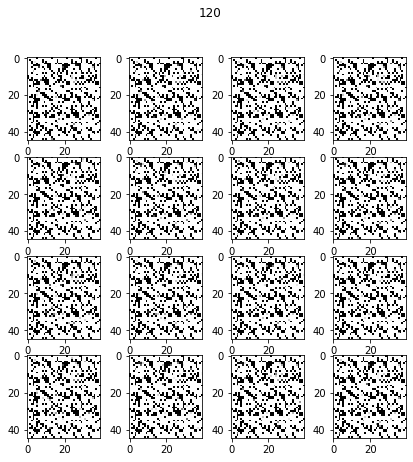

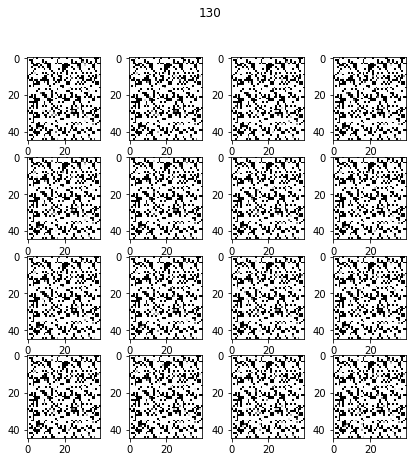

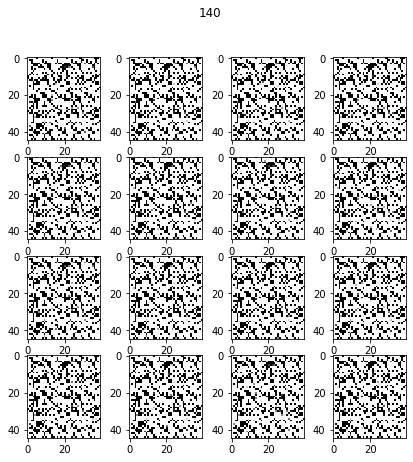

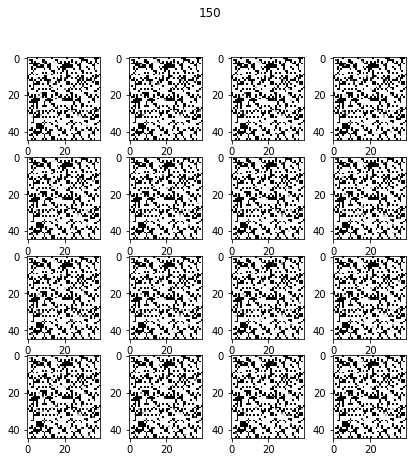

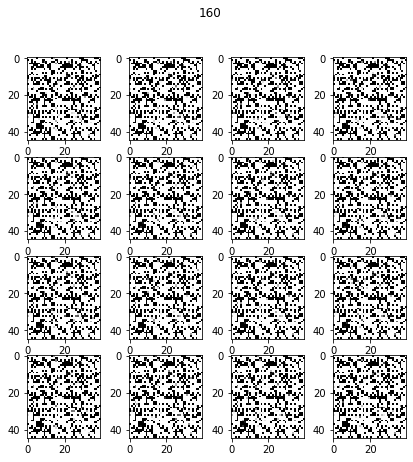

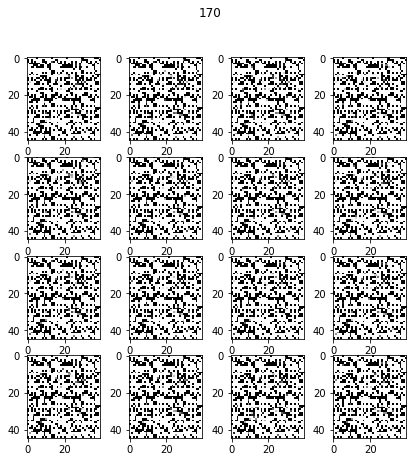

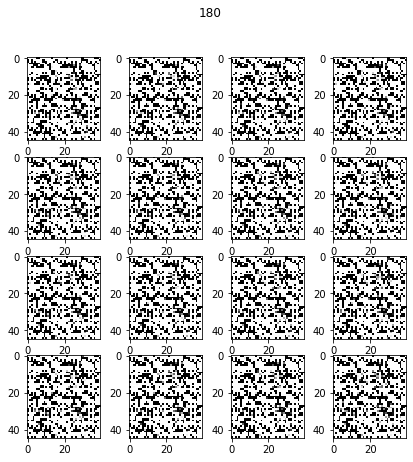

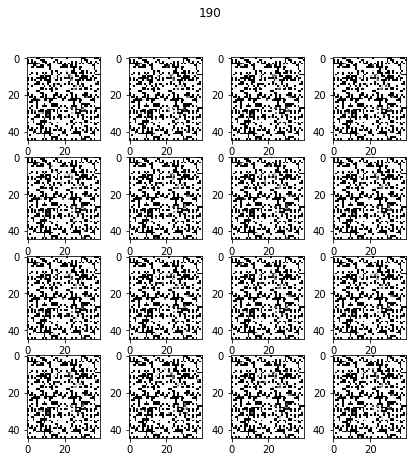

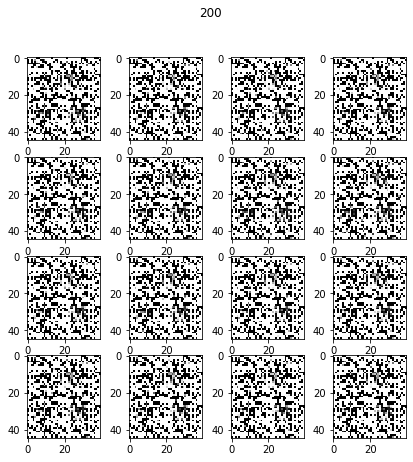

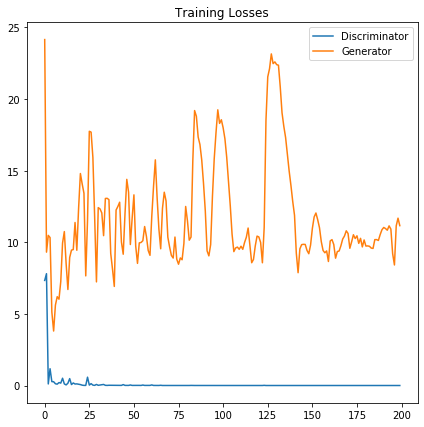

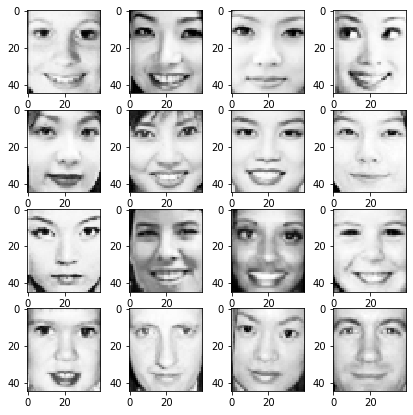

In [1]:
# 필요한 라이브러리 불러들임 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image as Im
import glob   
import os
%matplotlib inline

# 그래프 리셋
tf.reset_default_graph() 
# 재현성위한 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
##os.chdir('C:/Users/admin/Dropbox/저서/텐서플로_딥러닝/GANs_tensorflow/')
files=glob.glob('./face20/*.png')
img=[]        
for file in files:
    temp=Im.open(file)
     #계산 시간 절약위해 흑백으로 
    temp=temp.convert('L')
    temp=np.array(temp)
    img.append(temp)         

# 리스트를 array로
x=np.asarray(img)
n_cell=np.prod(x.shape[1:3]) # 45*40=1800
# 이미지를 벡터로 =[20,1800]
Ximg=np.reshape(x,[len(img),n_cell]) #=[20,1800]
Ximg=Ximg.reshape(20,45,40,1) # = [batch,height,width,channels]
# 관측치 수
sample_size=Ximg.shape[0] #=20
# 입력 변수 수
input_dim =Ximg.shape[1] #=1800


#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 50
# 미니배치 크기: 10
# 반복 수: 200
# 학습률 : 0.01
# Adam optimize 매개변수: 0.9, 0.999
learning_rate = 0.01 #학습률 
beta1=0.9 #Adam optimizer 매개변수
beta2=0.999 #Adam optimizer 매개변수
batch_size = 10 # 배치크기
z_size = 50 #잡음 크기
nepochs = 200 # 반복 수 
alpha=0.1# for leaky Relu, alpha=0 --> ReLu

# 드롭아웃에서 보존할 노드의 비율
keep_prob = tf.placeholder(tf.float32,name='keep_prob')



#------------------------------------------------
# 생성자 정의: 입력된 진짜 이미지와 유사한 가짜 이미지 생성
#------------------------------------------------
# 전치합성곱 연산 
# 패딩 없이(valid) 혹은 같은 크기 출력되는 패딩(same)
# 배치정규화, leaky-ReLu, tanh 활성함수  
def generator(z, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        G_conv1 = tf.layers.conv2d_transpose(z, 360, [2, 2], strides=(2, 2), padding='valid')
        G_conv1=tf.layers.batch_normalization(G_conv1, training=True) 
        G_conv1 = tf.maximum(alpha*G_conv1, G_conv1)              
        G_conv2 = tf.layers.conv2d_transpose(G_conv1, 180, [3, 3], strides=(2,2), padding='valid')
        G_conv2=tf.layers.batch_normalization(G_conv2, training=True) 
        G_conv2 = tf.maximum(alpha*G_conv2, G_conv2)
        G_conv3 = tf.layers.conv2d_transpose(G_conv2, 90, [3, 4], strides=(3, 4), padding='same')
        G_conv3=tf.layers.batch_normalization(G_conv3, training=True) 
        G_conv3 = tf.maximum(alpha*G_conv3, G_conv3)
        G_conv4 = tf.layers.conv2d_transpose(G_conv3, 1, [3, 3], strides=(3, 2), padding='same')
        G_out = tf.nn.tanh(G_conv4) 
        return G_out
    
#------------------------------------------------
# 판별자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
# 합성곱 연산
# 패딩 없이(valid) 혹은 입력과 같은 크기가 출력되도록 하는 패딩(same)
# 배치정규화 사용, leaky-ReLu 활성함수    
def discriminator(x, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        D_conv1 = tf.layers.conv2d(x, 90, [3, 3], strides=(3, 2), padding='same')
        D_conv1=tf.layers.batch_normalization(D_conv1, training=True) 
        D_conv1 = tf.maximum(alpha*D_conv1, D_conv1)
        D_conv2 = tf.layers.conv2d(D_conv1, 180, [3, 4], strides=(3, 4), padding='same')
        D_conv2=tf.layers.batch_normalization(D_conv2, training=True) 
        D_conv2 = tf.maximum(alpha*D_conv2, D_conv2)
        D_conv3 = tf.layers.conv2d(D_conv2, 360, [3, 3], strides=(2, 2), padding='valid')
        D_conv3=tf.layers.batch_normalization(D_conv3, training=True) 
        D_conv3 = tf.maximum(alpha*D_conv3, D_conv3)
        D_conv4 = tf.layers.conv2d(D_conv3, 1, [2, 2], strides=(2, 2), padding='valid')      
        D_out = tf.nn.sigmoid(D_conv4)     
        return D_out, D_conv4

# 진짜데이터 placeholder
X = tf.placeholder(tf.float32, shape=[None,45,40, 1])
# 잡음 placeholder
Z = tf.placeholder(tf.float32, shape=[None, 1,1,z_size])

# 가짜데이터
G = generator(Z)
# 진짜데이터의 판별망 결과 
D_real, D_logit_real = discriminator(X)
# 가짜데이터의 판별망 결과 
D_fake, D_logit_fake = discriminator(G, reuse=True)

# 비용함수 
# 진짜데이터는 1에 가깝게
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
# 가짜데이터는 0에 가깝게
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
# 생성자는 가짜데이터의 판별망 결과가 1이 되게 만들어야 한다. 
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))


# 각 신경망에 업데이트되는 변수 
T_vars = tf.trainable_variables() 
D_vars = [var for var in T_vars if var.name.startswith('discriminator')] 
G_vars = [var for var in T_vars if var.name.startswith('generator')] 

#Optimizer
D_solver = tf.train.AdamOptimizer(learning_rate,beta1,beta2).minimize(D_loss, var_list=D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate,beta1,beta2).minimize(G_loss, var_list=G_vars)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
sess=tf.Session(); 
sess.run(tf.global_variables_initializer())
losses = []
for epoch in range(nepochs):
    n_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(n_batch):
        if ii!=n_batch:
              batch_x=Ximg[ii*batch_size:(ii+1)*batch_size]
        else:
              batch_x=Ximg[(ii+1)*batch_size:] 
        #batch_images=tf.reshape(batch_images,[-1,45,40,1])      
        #tf.set_random_seed(ii)
        batch_x=2*batch_x-1
        batch_z = np.random.uniform(-1, 1, size=(batch_size,1,1, z_size)) 
        D_loss_curr,_ =sess.run([D_loss,D_solver], feed_dict={X: batch_x, Z: batch_z,keep_prob:0.9})
        G_loss_curr,_=sess.run([G_loss,G_solver], feed_dict={X: batch_x, Z: batch_z,keep_prob:0.9})            
        losss=D_loss_curr+G_loss_curr
        
    print('Epoch: {0}, Discriminator Loss: {1:7.4f}, Generator Loss: {2:7.4f}'  .format(epoch+1,D_loss_curr, G_loss_curr))
    losses.append((D_loss_curr, G_loss_curr,avg_loss))     
    
    # 10 에폭마다 가짜 이미지 그림  
    if (epoch+1)%10==0:
        tf.set_random_seed(0)
        sample_z = np.random.normal(0, 1, size=(16,1,1,z_size))
        gen_samples = sess.run(G,feed_dict={Z: sample_z})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((45,40)), cmap='Greys_r')
            
# 판별자, 생성자의 비용함수 그림   
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()    

#진짜 이미지 그림
f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(Ximg[ii].reshape(45,40),cmap='Greys_r')